<a href="https://colab.research.google.com/github/J-oyin/Dr.-Jimoh-Analysis/blob/main/ElevatedZeroMaize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statannotations


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

In [3]:
data = pd.read_excel("Dr.J_EZM.xlsx")

In [4]:
data.head()

,,Group,Time_in_open_arm,conditions,Subject
0,1,Healthy,53,baseline,RC1
1,2,Healthy,32,baseline,RC2
2,3,Healthy,22,baseline,RC3
3,4,Healthy,24,baseline,RC4
4,5,Healthy,20,baseline,RC5


In [7]:
from scipy.stats import levene

grouped = [data[data['Group']==grp]['Time_in_open_arm'].values for grp in
           ['Healthy', 'Resilient', 'S/DW', 'S/RG108', 'S/Esc',
            'S/LASA', 'S/LASA+ESC', 'S/HASA', 'S/HASA+ESC']]

stat, p = levene(*grouped)
print(f"Levene Test: stat={stat:.3f}, p={p:.3f}")

if p > 0.05:
    print("Variances are homogeneous across groups")
else:
    print("Variances are NOT homogeneous across groups")


Levene Test: stat=nan, p=nan
Variances are NOT homogeneous across groups


/tmp/ipython-input-3126213829.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = levene(*grouped)


In [8]:
df = data

In [9]:
df.head(10)

,,Group,Time_in_open_arm,conditions,Subject
0,1,Healthy,53,baseline,RC1
1,2,Healthy,32,baseline,RC2
2,3,Healthy,22,baseline,RC3
3,4,Healthy,24,baseline,RC4
4,5,Healthy,20,baseline,RC5
5,6,Healthy,30,post.indt,RC1
6,7,Healthy,12,post.indt,RC2
7,8,Healthy,44,post.indt,RC3
8,9,Healthy,34,post.indt,RC4
9,10,Healthy,24,post.indt,RC5


In [12]:
from scipy.stats import friedmanchisquare

# Convert 'Time_in_open_arm' to numeric, coercing errors
df['Time_in_open_arm'] = pd.to_numeric(df['Time_in_open_arm'], errors='coerce')

# Create an empty list to collect results
results = []

# Loop over each group and run the Friedman test
for grp, data in df.groupby('Group'):
    # Pivot data so each condition becomes a column (subjects as rows)
    pivot = data.pivot(index='Subject', columns='conditions', values='Time_in_open_arm')

    # Ensure conditions are in correct order and drop rows with NaN values
    pivot = pivot[['baseline', 'post.indt', 'post.tret']].dropna()

    # Check if there's enough data after dropping NaNs
    if len(pivot) < 1:
        print(f"Skipping Friedman test for group {grp} due to insufficient data after dropping NaNs.")
        continue

    # Run Friedman test
    stat, p = friedmanchisquare(pivot['baseline'], pivot['post.indt'], pivot['post.tret'])

    # Save results
    results.append({'Group': grp, 'Chi-square': stat, 'p-value': p})

# Convert results to dataframe
friedman_results = pd.DataFrame(results)
print(friedman_results)

        Group  Chi-square   p-value
0     Healthy    0.400000  0.818731
1   Resilient    3.263158  0.195620
2        S/DW    6.631579  0.036305
3       S/Esc    5.157895  0.075854
4      S/HASA    6.500000  0.038774
5  S/HASA+Esc    4.526316  0.104021
6      S/LASA    5.200000  0.074274
7  S/LASA+Esc    0.400000  0.818731
8     S/RG108    8.315789  0.015640


/tmp/ipython-input-1114989147.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


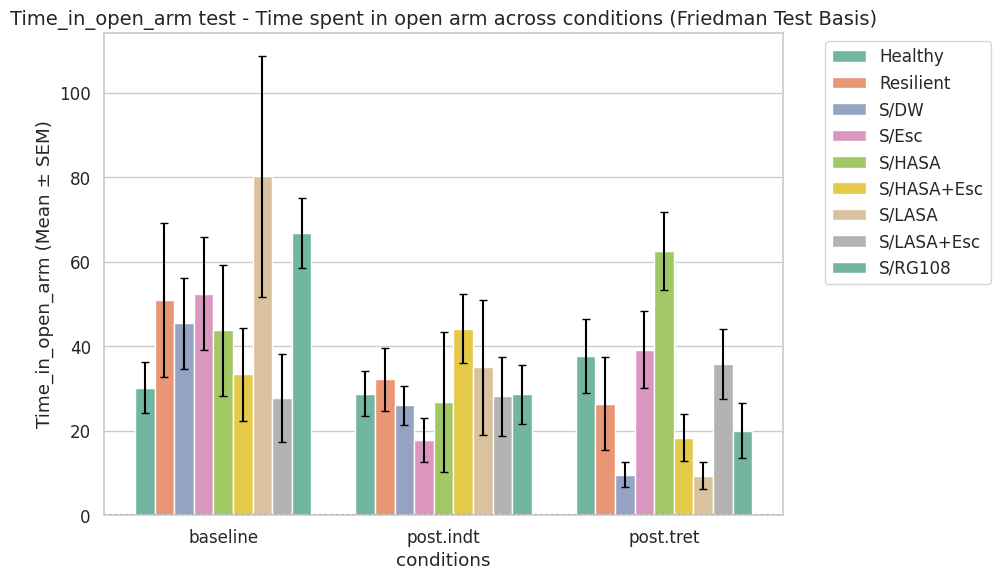

In [13]:
summary = (
    df.groupby(['Group', 'conditions'])['Time_in_open_arm']
      .agg(['mean', 'sem'])
      .reset_index()
)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.1)

# Create the barplot (mean values)
ax = sns.barplot(
    data=summary,
    x='conditions',
    y='mean',
    hue='Group',
    ci=None,  # we are providing our own SEM
    capsize=0.1,
    palette='Set2'
)

for i, row in summary.iterrows():
    group_index = list(summary['Group'].unique()).index(row['Group'])
    cond_index = list(summary['conditions'].unique()).index(row['conditions'])
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width()/2
    y = row['mean']
    plt.errorbar(x, y, yerr=row['sem'], fmt='none', ecolor='black', capsize=3)

plt.title("Time_in_open_arm test - Time spent in open arm across conditions (Friedman Test Basis)", fontsize=14)
plt.ylabel("Time_in_open_arm (Mean ± SEM)")
plt.xlabel("conditions")
plt.axhline(color='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


In [20]:
from scipy.stats import wilcoxon
import itertools

# Filter only the three groups
groups_of_interest = ['S/DW', 'S/HASA', 'S/RG108']
df_sub = df[df['Group'].isin(groups_of_interest)]


In [16]:
data_group = df[df['Group'] == 'Healthy']
data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Time_in_open_arm')
print("Pivot columns:", data_pivot.columns)


Pivot columns: Index(['baseline', 'post.indt', 'post.tret'], dtype='object', name='conditions')


In [21]:
import itertools
from scipy.stats import wilcoxon

condition_pairs = list(itertools.combinations(df['conditions'].unique(), 2))
results = []

for g in ['S/DW', 'S/HASA', 'S/RG108']:
    data_group = df[df['Group'] == g]
    data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Time_in_open_arm')

    for cond1, cond2 in condition_pairs:
        if cond1 in data_pivot.columns and cond2 in data_pivot.columns:
            valid = data_pivot[[cond1, cond2]].dropna()
            stat, p = wilcoxon(valid[cond1], valid[cond2])
            results.append({'Group': g, 'Comparison': f'{cond1} vs {cond2}', 'Statistic': stat, 'p-value': p})
        else:
            print(f"⚠️ Skipped {g}: missing {cond1} or {cond2}")

import pandas as pd
posthoc_df = pd.DataFrame(results)
print(posthoc_df)


     Group              Comparison  Statistic  p-value
0     S/DW   baseline vs post.indt        4.0   0.4375
1     S/DW   baseline vs post.tret        0.0   0.0625
2     S/DW  post.indt vs post.tret        0.0   0.1250
3   S/HASA   baseline vs post.indt        0.0   0.1250
4   S/HASA   baseline vs post.tret        2.0   0.3750
5   S/HASA  post.indt vs post.tret        1.0   0.1250
6  S/RG108   baseline vs post.indt        0.0   0.0625
7  S/RG108   baseline vs post.tret        0.0   0.0625
8  S/RG108  post.indt vs post.tret        3.0   0.6250


/tmp/ipython-input-2089308268.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-2089308268.py:10: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  ax = sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S/DW_baseline vs. S/DW_post.indt: Custom statistical test, P_val:2.000e-02
S/HASA_baseline vs. S/HASA_post.tret: Custom statistical test, P_val:1.000e-02
S/RG108_baseline vs. S/RG108_post.tret: Custom statistical test, P_val:3.000e-02


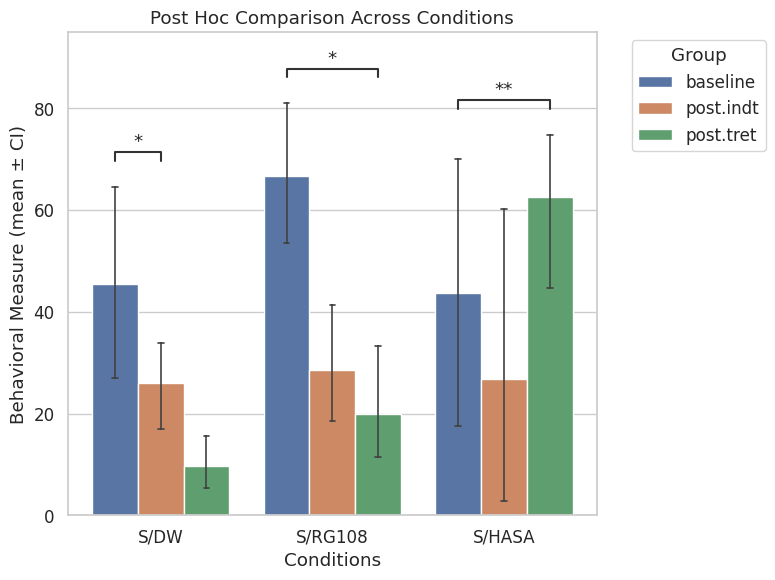

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# Filter only the three groups used in post hoc analysis
plot_df = df[df['Group'].isin(['S/DW', 'S/HASA', 'S/RG108'])]

# Set up figure
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_df,
    x='Group', y='Time_in_open_arm', hue='conditions',
    ci=95, capsize=0.1, errwidth=1.2
)

# Move legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Group')

# Define your post hoc pairs and p-values (update with your actual results)
pairs = pairs = [
    (("S/DW", "baseline"), ("S/DW", "post.indt")),
    (("S/HASA", "baseline"), ("S/HASA", "post.tret")),
    (("S/RG108", "baseline"), ("S/RG108", "post.tret"))
]
p_values = [0.02, 0.01, 0.03]  # replace with your actual post hoc p-values

# Add significance stars
annot = Annotator(ax, pairs, data=plot_df, x='Group', y='Time_in_open_arm', hue='conditions')
annot.configure(test=None, text_format='star', loc='inside', verbose=2)
annot.set_pvalues(p_values)
annot.annotate()

# Beautify the plot
plt.title('Post Hoc Comparison Across Conditions')
plt.xlabel('Conditions')
plt.ylabel('Behavioral Measure (mean ± CI)')
plt.tight_layout()
plt.show()
